# Guide to Extracting Data w/ APIs from the Whoop Strap 4.0

<img src="https://images.ctfassets.net/rbzqg6pelgqa/3CL3kZerAu072z1zr7jEYp/fa9fdf30e007201f03a645e3295f8c0f/introducing-4-0-whoop-body-any-wear-technology-en.jpg" width="500"/>

As Kanye once [said](https://www.youtube.com/watch?v=8fbyfDbi-MI),

> Scoop-diddy-whoop
>
> Whoop-diddy-scoop

While we certainly won't be rapping in this notebook, we will be using the [WHOOP 4.0](https://www.whoop.com/membership/strap/), a small wearable that fits onto your wrist as shown above! Featuring a light, discreet wristband that is also waterproof, the WHOOP 4.0 offers comfortable [physical activity](https://github.com/alrojo/wearipedia/tree/main/metrics/physical-activity) and [sleep](https://github.com/alrojo/wearipedia/tree/main/metrics/sleep) tracking with wireless charging and an app with useful calculated metrics such as strain and recovery.

We've used the WHOOP 4.0 for a while now, and we'll show you how to extract its data, visualize steep stages, and compute correlations and other statistical measures based on your data! While you will need a WHOOP 4.0 set up to actually collect the data, the data *extraction* requires only an internet connection and your username and password.

This is a comprehensive, clear guide to extract your data from the WHOOP 4.0 using the official WHOOP [Application Programming Interface (API)](https://developer.whoop.com/api).

We will be able to extract the following parameters:

| **Parameter Name**       | **Sampling Frequency** |
|--------------------------|------------------------|
| **Strain**               | Per cycle, per workout |
| **Kilojoules (energy burned)** | Per cycle, per workout |
| **Average heart rate**   | Per cycle, per workout |
| **Maximum heart rate**   | Per cycle, per workout |
| **Total in bed time**    | Per sleep              |
| **Total awake time**     | Per sleep              |
| **Total light sleep time** | Per sleep            |
| **Total slow wave sleep time** | Per sleep        |
| **Total REM sleep time** | Per sleep              |
| **Sleep cycle count**    | Per sleep              |
| **Sleep disturbance count** | Per sleep            |
| **Baseline sleep need**  | Per sleep              |
| **Sleep need from sleep debt** | Per sleep         |
| **Sleep need from recent strain** | Per sleep       |
| **Sleep need from recent nap** | Per sleep          |
| **Respiratory rate**     | Per sleep              |
| **Sleep performance percentage** | Per sleep        |
| **Sleep consistency percentage** | Per sleep        |
| **Sleep efficiency percentage** | Per sleep         |
| **Workout distance**     | Per workout            |
| **Workout altitude gain** | Per workout          |
| **Workout altitude change** | Per workout         |
| **Workout zone zero duration** | Per workout       |
| **Workout zone one duration** | Per workout        |
| **Workout zone two duration** | Per workout        |
| **Workout zone three duration** | Per workout      |
| **Workout zone four duration** | Per workout       |
| **Workout zone five duration** | Per workout       |

In this guide, we sequentially cover the following **nine** topics to extract from the WHOOP 4.0 API:
1. **Setup**
2. **Authentication and Authorization**
    - Requires only creating an app with your email and password.
3. **Data Extraction**
    - You can get data from the API in a couple lines of code.
4. **Data Exporting**
    - The data can be exported to json format or excel.
5. **Adherence**
    - We visualize when data was collected given start date and end date plotting a usage block plot.
6. **Visualization**
    - 6.1: We plot average heart rate over a specified start and end date
    - 6.2: We plot respirator rate in sleep over a specified start and end date
7. **Advanced Visualization**
    - 7.1: We reproduce a day-by-day week-long plot of hours slept and sleep needed, which is displayed in the mobile app originally.
    - 7.2: We reproduce a day-by-day week-long plot of sleep performance percentage, which is displayed in the mobile app originally.
8. **Outlier Detection and Data Cleaning**
    - We check for anomalies in the data using the z-score method, and clean the data
9. **Statistical Data Analysis**
    - 9.1: We try to find a correlation between the sleep performance and total time in bed. We find that the two are correlated
    - 9.2: We try to check whether strain is correlated to average heart rate in a day. We find that for our data this is statistically significant.


Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data.

# 1. Setup

## 1.1 Data Receiver Setup

When purchasing the whoop strap, the system usually prompts the buyer to create a Whoop account associated with the new strap.

<img src="https://imgur.com/NcmW4nM.png" width="400px"></img>

Please follow the steps below.
1. Create an email address for the participant, say, `foo@email.com`.
2. Create a Whoop account for the strap with the email address `foo@email.com` and a password, say `whatever_password`.
3. Distribute the device and provide the email and the password to the study participant. Instruct them to follow the participant setup letter below.
5. Install the `wearipedia` Python package to extract data from this device.

## 1.2 Study participant setup and usage

Dear Participant,

First, download the WHOOP app from your phone's application store (iOS App Store or Play Store). Ideally, take the sensor out of its strap and charge it before proceeding. Login to the app with the email (say, `foo@email.com`) and password (`whatever_password`) provided by the research coordinator. To pair the whoop strap with your phone, follow the on-screen instructions in the app. Make sure to wear the strap for at least 24 hours for meaningful data collection to occur.

Best,

Wearipedia

## 1.3 Wearipedia Library Install
Relevant libraries are imported below. Just run the code to import all the libraries including our device data extractor, `Wearipedia`.

In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
from datetime import datetime
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import math
!pip install july
import july

!pip install --no-cache-dir git+https://github.com/a-llison-lau/wearipedia.git
import wearipedia
device = wearipedia.get_device('whoop/whoop_4')

  Cloning https://github.com/a-llison-lau/wearipedia.git to /tmp/pip-req-build-tc0n4p5s
  Running command git clone --filter=blob:none --quiet https://github.com/a-llison-lau/wearipedia.git /tmp/pip-req-build-tc0n4p5s
  Resolved https://github.com/a-llison-lau/wearipedia.git to commit 38c599b00e934d0e9f73967b329567d2abb7dfa8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 2. Authentication and Authorization

To obtain access to data, authentication is required. We will focus on creating an application with OAuth2 access to the API. The end user for your application must login and give explicit permission to share his or her data.

First, follow the steps listed below:

1. Visit the [developer portal](https://developer-dashboard.whoop.com/login) and login with the email and password you registered when you purchased the Whoop strap for the study participant.
2. Once logged in, click `create new app`. An "app" can have up to 10 study participants at a time and manages the data extraction for all the participants in a team in the app, which we will explain in the following steps.
3. When creating an app, you will be required to enter the "App name", "contact" and "redirect URL".
  - Enter whatever name you want under "App name".
  - For "contact", enter your own email (**not** the one for the study participant).
  - For "redirect URL", enter [https://wearipedia.com/](https://wearipedia.com/)
  - For scopes, check all boxes.

In the end, you should see something like the image below.

<img src="https://imgur.com/DwwaXS6.png" width=500px></img>

Navigate to "team" in the developer portal and click "invite" in the application you just made. You will be prompted to enter a whoop member email. Enter the email you have registered for the study participant (`foo@email.com`). Instruct the study participant to accept the invitation.

*Note*: If there is a second study participant, you would not need to create another app. Simply login to the developer portal and invite the study participant to the app using the email you have registered for his or her whoop strap.

To be able to make requests to the API and extract the data we need, we need to first issue an access token. This access token will serve as our key to the data. While you don't necessarily need to be familiar with how the issuing of the authtoken occurs, you can learn more about it by visiting [the Auth0 Docs](https://auth0.com/docs/get-started/authentication-and-authorization-flow/call-your-api-using-the-authorization-code-flow#prerequisites).


To extract data, you will need the client ID and client secret. You will also need to authorization of the study participant, explained below.

In [2]:
#@title Enter your credentials below (available in the developer portal under your app) or enter synthetic to be True if you do not want real data
CLIENT_ID = "11c6hij7-e1e1-6890-6453-e163ba2d8989" #@param {type:"string"}
CLIENT_SECRET = "888csdkjfn99028481807c7koi8pft19e0eoijror-g93jfjdknssda" #@param {type:"string"}
use_synthetic = True #@param {type:"boolean"}
credentials = {"client_id": CLIENT_ID, "client_secret": CLIENT_SECRET}
if not use_synthetic:
  device.authenticate(credentials)

Run the cell above. If `CLIENT_ID` and `CLIENT_SECRET` are entered and `use_synthetic` is selected to be `False`, you should see an Authorization URL. Following the Authorization URL, the study participant will be asked to grant access to specific scopes of data. Grant access and you will be redirected back to [https://www.wearipedia.com/](https://www.wearipedia.com/). Then, copy the URL and paste into the textfield above. You should see "Authentication succeeded".

# 3. Data Extraction

Data can be extracted via `wearipedia`, our open-source Python package that unifies dozens of complex wearable device APIs into one simple, common interface.

First, we'll set a date range and then extract all of the data within that date range. You can select whether you would like synthetic data or not with the checkbox in the code cell above. Please go back to step 5 of Authentication/Authorization where you can uncheck the "use_synthetic" box to instead use your own *real* data via Whoop API calls.

Run the cell below to extract **the sleeps data, (physiological) cycles data and workouts data**.

In [3]:
#@title Extract data via the API
#set start and end dates - this will give you all the data from 2020-01-01 (January 1st, 2020) to 2022-12-01 (December 1st, 2022), for example
start_date='2022-04-01' #@param {type:"date"}
end_date='2022-08-02' #@param {type:"date"}
params = {"start": start_date, "end": end_date}

sleeps_df = device.get_data("sleeps", params=params)
cycles_df = device.get_data("cycles", params=params)
workouts_df = device.get_data("workouts", params=params)

Let's display the first few rows of the (physiological) cycles data `cycles_df`. Each row denotes one cycle, and you can see the corresponding information about that cycle in different columns.

In [4]:
cycles_df.head()

,user_id,id,created_at,updated_at,start,end,timezone_offset,score_state,score
0,1320,39593438,2022-06-17T00:49:26.404000Z,2022-06-17T03:29:44.095000Z,2022-06-16T00:42:50.317000Z,2022-06-16T21:50:57.404000Z,-08:00,SCORED,"{'strain': 17.7373987, 'kilojoule': 8976.222, ..."
1,1320,12569117,2022-06-16T02:25:00.317000Z,2022-06-16T04:28:22.633000Z,2022-06-15T02:56:27.157000Z,2022-06-16T00:42:50.317000Z,-08:00,SCORED,"{'strain': 17.0056305, 'kilojoule': 7900.244, ..."
2,1320,95592030,2022-06-15T04:53:07.157000Z,2022-06-15T06:23:26.929000Z,2022-06-14T08:00:00.064000Z,2022-06-15T02:56:27.157000Z,-08:00,SCORED,"{'strain': 11.0708427, 'kilojoule': 6074.834, ..."
3,1320,27122926,2022-06-13T23:10:41.371000Z,2022-06-14T01:39:47.347000Z,2022-06-13T02:42:37.064000Z,2022-06-13T21:34:40.371000Z,-08:00,SCORED,"{'strain': 10.8683659, 'kilojoule': 6165.322, ..."
4,1320,68211070,2022-06-13T05:02:20.064000Z,2022-06-13T06:34:37.261000Z,2022-06-12T08:00:00.458000Z,2022-06-13T02:42:37.064000Z,-08:00,SCORED,"{'strain': 17.4993806, 'kilojoule': 8138.781, ..."


Here are some basic things we can do with our dataframe:
1. Pick out a specific cycle given start time / or end time

In [5]:
#@title Show data for a specific date
start_date='2022-04-26' #@param {type:"date"}
df_copy = sleeps_df.copy()
df_copy['start'] = pd.to_datetime(df_copy['start'])
desired_date = pd.Timestamp(start_date).date()

sleep = df_copy[df_copy['start'].dt.date == desired_date]
sleep

,user_id,id,created_at,updated_at,start,end,timezone_offset,nap,score_state,score
50,16043,53548,2022-04-27T08:22:04.244000Z,2022-04-27T10:59:05.035000Z,2022-04-26 21:04:49.884000+00:00,2022-04-27T05:52:09.244000Z,-08:00,False,SCORED,{'stage_summary': {'total_in_bed_time_milli': ...


2. Look into the scores of this specific physiological cycle given.

In [6]:
sleep_score = pd.json_normalize(sleep['score'])
sleep_score

,respiratory_rate,sleep_performance_percentage,sleep_consistency_percentage,sleep_efficiency_percentage,stage_summary.total_in_bed_time_milli,stage_summary.total_awake_time_milli,stage_summary.total_no_data_time_milli,stage_summary.total_light_sleep_time_milli,stage_summary.total_slow_wave_sleep_time_milli,stage_summary.total_rem_sleep_time_milli,stage_summary.sleep_cycle_count,stage_summary.disturbance_count,sleep_needed.baseline_milli,sleep_needed.need_from_sleep_debt_milli,sleep_needed.need_from_recent_strain_milli,sleep_needed.need_from_recent_nap_milli
0,14.85,87,84,92.51,26608729,1397462,0,13860381,6143115,5207769,2,4,24966116,3906,17775,-16424


# 4. Data Exporting

In this section, we export all the data to formats compatible with widely used scientific computing software like R, Excel, Google Sheets, and MATLAB. Since each parameter is retrieved in a different format such as dictionaries, we categorize parameters with similar formats. Then, we process the data into pandas dataframes.

Here you can select whether to export the data to JSON, which can be read by R and MATLAB, or Excel.

In [7]:
#@title Select data to export
data = "cycles" # @param ["sleeps", "cycles", "workouts"]
export_type = "json" # @param ["json", "excel"]

if data == "sleeps":
  flattened_scores = pd.json_normalize(sleeps_df['score'])
  sleeps_df_copy = sleeps_df.copy()
  sleeps_df_copy.drop(columns=['score'], inplace=True)
  sleeps_df_copy = pd.concat([sleeps_df_copy, flattened_scores], axis=1)
  sleeps_df_copy['start'] = pd.to_datetime(sleeps_df_copy['start'])
  sleeps_df_copy['end'] = pd.to_datetime(sleeps_df_copy['end'])
  sleeps_df_copy['updated_at'] = pd.to_datetime(sleeps_df_copy['updated_at'])
  sleeps_df_copy['created_at'] = pd.to_datetime(sleeps_df_copy['created_at'])
  sleeps_df_copy['start'] = sleeps_df_copy['start'].dt.tz_localize(None)
  sleeps_df_copy['end'] = sleeps_df_copy['end'].dt.tz_localize(None)
  sleeps_df_copy['updated_at'] = sleeps_df_copy['updated_at'].dt.tz_localize(None)
  sleeps_df_copy['created_at'] = sleeps_df_copy['created_at'].dt.tz_localize(None)

  sleeps_df_copy['total_in_bed_time_milli'] = sleeps_df_copy['stage_summary.total_in_bed_time_milli']
  sleeps_df_copy['total_awake_time_milli'] = sleeps_df_copy['stage_summary.total_awake_time_milli']
  sleeps_df_copy['total_no_data_time_milli'] = sleeps_df_copy['stage_summary.total_no_data_time_milli']
  sleeps_df_copy['total_light_sleep_time_milli'] = sleeps_df_copy['stage_summary.total_light_sleep_time_milli']
  sleeps_df_copy['total_slow_wave_sleep_time_milli'] = sleeps_df_copy['stage_summary.total_slow_wave_sleep_time_milli']
  sleeps_df_copy['total_rem_sleep_time_milli'] = sleeps_df_copy['stage_summary.total_rem_sleep_time_milli']
  sleeps_df_copy['sleep_cycle_count'] = sleeps_df_copy['stage_summary.sleep_cycle_count']
  sleeps_df_copy['disturbance_count'] = sleeps_df_copy['stage_summary.disturbance_count']
  sleeps_df_copy['baseline_milli'] = sleeps_df_copy['sleep_needed.baseline_milli']
  sleeps_df_copy['need_from_sleep_debt_milli'] = sleeps_df_copy['sleep_needed.need_from_sleep_debt_milli']
  sleeps_df_copy['need_from_recent_strain_milli'] = sleeps_df_copy['sleep_needed.need_from_recent_strain_milli']
  sleeps_df_copy['need_from_recent_nap_milli'] = sleeps_df_copy['sleep_needed.need_from_recent_nap_milli']
  columns_to_drop = [
      'stage_summary.total_in_bed_time_milli',
      'stage_summary.total_awake_time_milli',
      'stage_summary.total_no_data_time_milli',
      'stage_summary.total_light_sleep_time_milli',
      'stage_summary.total_slow_wave_sleep_time_milli',
      'stage_summary.total_rem_sleep_time_milli',
      'stage_summary.sleep_cycle_count',
      'stage_summary.disturbance_count',
      'sleep_needed.baseline_milli',
      'sleep_needed.need_from_sleep_debt_milli',
      'sleep_needed.need_from_recent_strain_milli',
      'sleep_needed.need_from_recent_nap_milli'
  ]

  sleeps_df_copy.drop(columns=columns_to_drop, inplace=True)
  if export_type == "json":
    sleeps_df_copy.to_json("sleeps_data.json", orient="records", date_format="iso")
    print("Data exported to: \"sleeps_data.json\"")
  else:
    sleeps_df_copy.to_excel("sleeps_data.xlsx", index=False)
    print("Data exported to: \"sleeps_data.xlsx\"")
elif data == "cycles":
  flattened_scores = pd.json_normalize(cycles_df['score'])
  cycles_df_copy = cycles_df.copy()
  cycles_df_copy.drop(columns=['score'], inplace=True)
  cycles_df_copy = pd.concat([cycles_df_copy, flattened_scores], axis=1)
  cycles_df_copy['start'] = pd.to_datetime(cycles_df_copy['start'])
  cycles_df_copy['end'] = pd.to_datetime(cycles_df_copy['end'])
  cycles_df_copy['updated_at'] = pd.to_datetime(cycles_df_copy['updated_at'])
  cycles_df_copy['created_at'] = pd.to_datetime(cycles_df_copy['created_at'])
  cycles_df_copy['start'] = cycles_df_copy['start'].dt.tz_localize(None)
  cycles_df_copy['end'] = cycles_df_copy['end'].dt.tz_localize(None)
  cycles_df_copy['updated_at'] = cycles_df_copy['updated_at'].dt.tz_localize(None)
  cycles_df_copy['created_at'] = cycles_df_copy['created_at'].dt.tz_localize(None)
  if export_type == "json":
    cycles_df_copy.to_json("cycles_data.json", orient="records", date_format="iso")
    print("Data exported to: \"cycles_data.json\"")
  else:
    cycles_df_copy.to_excel("cycles_data.xlsx", index=False)
    print("Data exported to: \"cycles_data.xlsx\"")
else:
  flattened_scores = pd.json_normalize(workouts_df['score'])
  workouts_df_copy = workouts_df.copy()
  workouts_df_copy.drop(columns=['score'], inplace=True)
  workouts_df_copy = pd.concat([workouts_df_copy, flattened_scores], axis=1)
  workouts_df_copy['start'] = pd.to_datetime(workouts_df_copy['start'])
  workouts_df_copy['end'] = pd.to_datetime(workouts_df_copy['end'])
  workouts_df_copy['updated_at'] = pd.to_datetime(workouts_df_copy['updated_at'])
  workouts_df_copy['created_at'] = pd.to_datetime(workouts_df_copy['created_at'])
  workouts_df_copy['start'] = workouts_df_copy['start'].dt.tz_localize(None)
  workouts_df_copy['end'] = workouts_df_copy['end'].dt.tz_localize(None)
  workouts_df_copy['updated_at'] = workouts_df_copy['updated_at'].dt.tz_localize(None)
  workouts_df_copy['created_at'] = workouts_df_copy['created_at'].dt.tz_localize(None)
  workouts_df_copy['zone_zero_milli'] = workouts_df_copy['zone_duration.zone_zero_milli']
  workouts_df_copy['zone_one_milli'] = workouts_df_copy['zone_duration.zone_one_milli']
  workouts_df_copy['zone_two_milli'] = workouts_df_copy['zone_duration.zone_two_milli']
  workouts_df_copy['zone_three_milli'] = workouts_df_copy['zone_duration.zone_three_milli']
  workouts_df_copy['zone_four_milli'] = workouts_df_copy['zone_duration.zone_four_milli']
  workouts_df_copy['zone_five_milli'] = workouts_df_copy['zone_duration.zone_five_milli']
  columns_to_drop = [
      'zone_duration.zone_zero_milli',
      'zone_duration.zone_one_milli',
      'zone_duration.zone_two_milli',
      'zone_duration.zone_three_milli',
      'zone_duration.zone_four_milli',
      'zone_duration.zone_five_milli'
  ]
  workouts_df_copy.drop(columns=columns_to_drop, inplace=True)
  if export_type == "json":
    workouts_df_copy.to_json("workouts_data.json", orient="records", date_format="iso")
    print("Data exported to: \"workouts_data.json\"")
  else:
    workouts_df_copy.to_excel("workouts_data.xlsx", index=False)
    print("Data exported to: \"workouts_data.xlsx\"")

Data exported to: "cycles_data.json"


# 5. Adherence

We are interested in knowing on which days our user used the strap to track sleep. We can plot a graph to visualize this.

To simulate nonadherence in sleep tracking, we randomly remove a portion of the recorded sleep entries from the dataset. This process mimics scenarios where individuals may forget to wear their sleep tracking device or deliberately choose not to use it on certain nights.

In this example, our synthetic data has sleep recorded for every day between the initial specified start date and end date, so we will randomly select a percentage of recorded sleep entries to remove from the dataset. We create a binary indicator for each day in the specified date range, where 1 indicates that sleep data is recorded for that day and 0 indicates no recorded sleep data. Finally, we visualize the presence of recorded sleep data over the specified date range using a step plot. The plot illustrates the simulated nonadherence by showing gaps in the recorded sleep data on certain days.

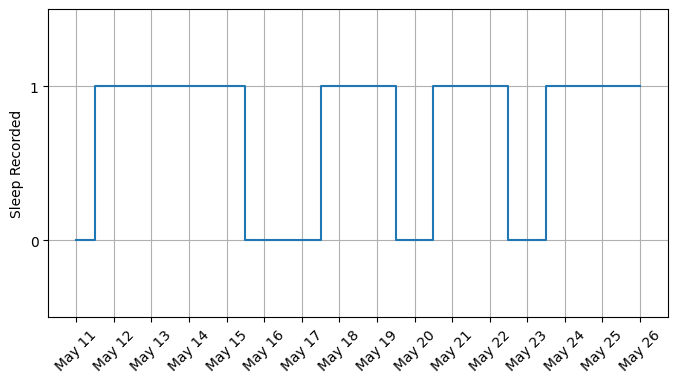

In [8]:
#@title Specify start and end dates where sleeps are tracked
start_date = "2022-05-11" #@param {type:"date"}
end_date = "2022-05-26" #@param {type:"date"}

date_range = pd.date_range(start=start_date, end=end_date)
sleep_dates = pd.to_datetime(sleeps_df['start']).dt.date
sleep_dates = sleep_dates[::-1]

# Remove 40% of the data
np.random.seed(44)
percentage_to_remove = 0.4
num_entries_to_remove = int(len(sleep_dates) * percentage_to_remove)
indices_to_remove = sleep_dates.sample(num_entries_to_remove).index
sleep_dates_cleaned = sleep_dates.drop(indices_to_remove)

presence = [1 if pd.Timestamp(date).date() in sleep_dates_cleaned.values else 0 for date in date_range]
plt.figure(figsize=(8, 4))
plt.style.use('fast')
plt.step(date_range, presence, where='mid')
plt.ylabel('Sleep Recorded')
plt.ylim(bottom=-0.5, top=1.5)
plt.yticks([0, 1])
formatted_dates = [date.strftime('%B %d') for date in date_range]
plt.xticks(date_range, formatted_dates)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 6. Visualization

Now that we have extracted some data, let us visualize it. In this section, we'll create a straightforward and customizable plot to visualize four types of data.

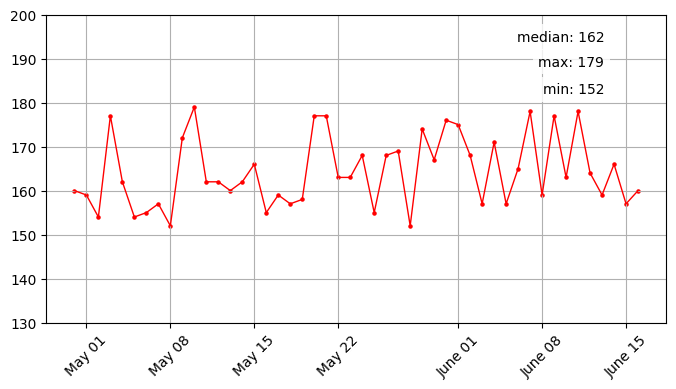

In [9]:
#@title 6.1 Plotting data over a specified start and end date
feature = "maximum heart rate" # @param ["average heart rate", "maximum heart rate", "kilojoule", "strain"]
start_date = "2022-04-30" #@param {type:"date"}
end_date = "2022-06-30" #@param {type:"date"}

filtered_df = cycles_df.copy()
filtered_df['start'] = pd.to_datetime(filtered_df['start'])
filtered_df = filtered_df[(filtered_df['start'] >= start_date) & (filtered_df['start'] <= end_date)]
dates = filtered_df['start'].dt.date
dates = dates[::-1]

cycle_scores = filtered_df['score']
if feature == "average heart rate":
  res_column = cycle_scores.apply(lambda x: x['average_heart_rate'])
elif feature == "maximum heart rate":
  res_column = cycle_scores.apply(lambda x: x['max_heart_rate'])
elif feature == "kilojoule":
  res_column = cycle_scores.apply(lambda x: x['kilojoule'])
else:
  res_column = cycle_scores.apply(lambda x: x['strain'])

medr = np.median(res_column)
maxr = np.max(res_column)
minr = np.min(res_column)

plt.figure(figsize=(8, 4))
plt.style.use('default')
plt.scatter(dates, res_column, s=5, c='r')
plt.plot(dates, res_column, c='r', linewidth=1)
if feature == "average heart rate":
  plt.ylim(bottom=40, top=100)
elif feature == "maximum heart rate":
  plt.ylim(bottom=130, top=200)
elif feature == "kilojoule":
  plt.ylim(bottom=4000, top=10000)
else:
   plt.ylim(bottom=0, top=25)
xticks = plt.xticks(rotation=45)
date_strings = [t.get_text() for t in plt.xticks()[1]]
formatted_dates = [pd.to_datetime(date_str).strftime("%B %d") for date_str in date_strings]
xticks = plt.xticks(ticks=plt.xticks()[0], labels=formatted_dates)
plt.grid(True)
plt.text(0.9, 0.95, f'median: {int(medr)}', ha='right', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.text(0.9, 0.87, f'max: {int(maxr)}', ha='right', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.text(0.9, 0.78, f'min: {int(minr)}', ha='right', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.show()

Next, let us also use a calendar plot from the library [`july`](https://github.com/e-hulten/july/tree/master?tab=readme-ov-file) to visualize respiratory rate in sleep over a specified start and end date.

<Axes: title={'center': 'Respiratory Rate in Sleep'}>

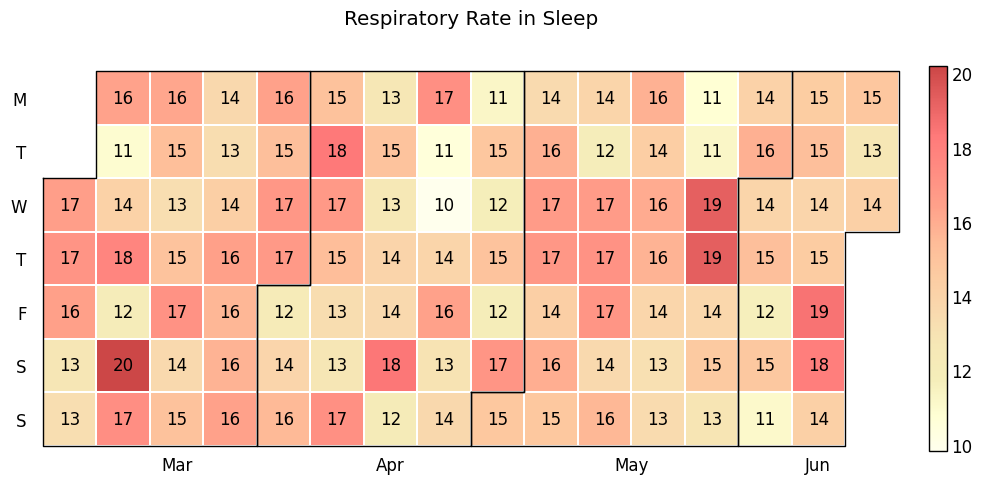

In [10]:
#@title 6.2 Respiratory rate in sleep over a specified start and end date

start_date = "2022-02-28" #@param {type:"date"}
end_date = "2022-07-10" #@param {type:"date"}

filtered_df = sleeps_df.copy()
filtered_df['start'] = pd.to_datetime(filtered_df['start'])
filtered_df = filtered_df[(filtered_df['start'] >= start_date) & (filtered_df['start'] <= end_date)]

dates = filtered_df['start'].dt.date
sleep_scores = filtered_df['score']
res_column = sleep_scores.apply(lambda x: x['respiratory_rate'])

data = np.zeros(len(dates))
for i, score in enumerate(res_column):
    data[i] = score

fig = july.heatmap(dates, data, month_grid=True, year_label=False,
             horizontal=True, value_label=True, colorbar=True, fontfamily="sans-serif", title="Respiratory Rate in Sleep")

# 7. Advanced Visualization

Now, we'll do some more advanced plotting. First, let's plot how much sleep you have had compared to the amount of sleep needed, replicating the plot from the app...

<img src="https://imgur.com/jx5CmC3.png" width="400">

*Above is a plot from the app*

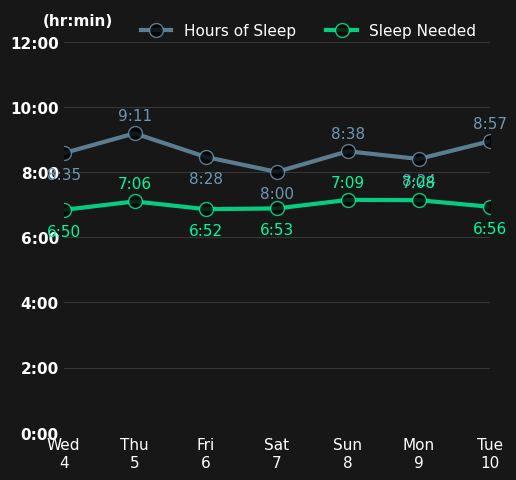

In [11]:
#@title 7.1 Sleep needed and hours of sleep weekly view
start_date = "2022-05-03" #@param {type:"date"}

sleeps_df_copy = sleeps_df.copy()

# Convert relevant columns to datetime format
sleeps_df_copy['day'] = pd.to_datetime(sleeps_df_copy['start']).dt.strftime('%Y-%m-%d')

# start_idx = np.where(sleeps_df_copy['day'] == start_date)[0][0]

start_idx = np.where(sleeps_df_copy['day'] == start_date)[0][0]

# only plotting a week
PLOT_LENGTH = 7

extracted_data = []

# Iterate over rows in sleep_df
for index, row in sleeps_df.iterrows():
    # Extract relevant information from the 'score' column
    score_dict = row['score']
    stage_summary = score_dict.get('stage_summary', {})
    sleep_needed = score_dict.get('sleep_needed', {})

    # Create a dictionary with the extracted information
    data = {
        'start': row['start'],
        'sleep_performance_percentage': score_dict['sleep_performance_percentage'],
        'total_in_bed_time_milli': stage_summary.get('total_in_bed_time_milli', None),
        'baseline_milli': sleep_needed.get('baseline_milli', None),
        'need_from_sleep_debt_milli': sleep_needed.get('need_from_sleep_debt_milli', None),
        'need_from_recent_strain_milli': sleep_needed.get('need_from_recent_strain_milli', None),
        'need_from_recent_nap_milli': sleep_needed.get('need_from_recent_nap_milli', None),

    }

    # Append the dictionary to the list
    extracted_data.append(data)

# Create a new DataFrame from the list of dictionaries
extracted_df = pd.DataFrame(extracted_data)
extracted_df['sleep_needed'] = (
    extracted_df['baseline_milli'] +
    extracted_df['need_from_sleep_debt_milli'] +
    extracted_df['need_from_recent_strain_milli'] +
    extracted_df['need_from_recent_nap_milli']
)

# Now, you can drop the individual columns
columns_to_drop = ['baseline_milli', 'need_from_sleep_debt_milli', 'need_from_recent_strain_milli', 'need_from_recent_nap_milli']
extracted_df = extracted_df.drop(columns=columns_to_drop, axis=1)
extracted_df['start'] = pd.to_datetime(extracted_df['start'])  # Convert 'start' column to datetime format
df_sorted = extracted_df.sort_values(by='start')

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def ms_to_hm(ms):
    hours = int(ms / (60 * 60 * 1000))
    minutes = round((ms / (60 * 1000)) % 60)

    return hours, minutes

def ms_to_text(ms):
    hours, minutes = ms_to_hm(ms)

    return f'{hours:02}:{minutes:02}'

def determine_offset(i, values, sleep_dur):
    """
    Takes in array-like values and an index for that array, then
    computes what offset the text annotation should have. Intuition
    is that text annotation should not collide with the lines.

    NOTE: We attempted to use https://github.com/Phlya/adjustText, but
    could not get it to work.
    """

    if i == 0:
        # put above if going down, otherwise below
        offset = (values[0] > values[1]) * 2 - 1
    elif i == sleep_dur.shape[0] - 1:
        # put above if going up, otherwise below
        offset = (values[i] > values[i - 1]) * 2 - 1
    elif values[i] < values[i+1] and values[i] < values[i-1]:
        # valley
        offset = -1
    elif values[i] > values[i+1] and values[i] > values[i-1]:
        # peak
        offset = 1
    elif values[i] > values[i+1] and values[i] < values[i-1]:
        # maintain same sign of slope (downwards)
        if values[i] - values[i+1] > values[i-1] - values[i]:
            offset = 1
        else:
            offset = -1
    elif values[i] < values[i+1] and values[i] > values[i-1]:
        # maintain same sign of slope (upwards)
        if values[i+1] - values[i] > values[i] - values[i-1]:
            offset = -1
        else:
            offset = 1

    return offset

    # this function turns a string like '2022-04-28' into 'Thu\n28'
def day_label_to_fig_label(day):
    weekday = weekdays[datetime.strptime(day, '%Y-%m-%d').weekday()]
    day_num = str(int(day.split('-')[-1]))

    return weekday + '\n' + day_num

def plot_line_fancy(X, Y, label, sleep_dur, max_sleep_time, color=None):

    plt.plot(X, Y / (60 * 60 * 1000), marker='o', markerfacecolor='black',
             markeredgewidth=1, markersize=10, linewidth=3, label=label, alpha=0.8,
             color=color)

    # add text annotations
    for i, dur in enumerate(Y):
        offset = determine_offset(i, np.array(Y), sleep_dur)
        plt.text(i, 0.6 * offset + dur / (60 * 60 * 1000) - 0.2, ms_to_text(dur).lstrip('0'),
                 ha='center', fontsize=11, color=color)

    # set to maximum y-value (in this case it is 12 hours)
    max_sleep_hours = math.ceil(max(13, max_sleep_time / 3.6e+6))
    plt.ylim(0, max_sleep_hours)

    # set the labels on the left and bottom to match the app's plot
    plt.xticks(ticks=np.arange(PLOT_LENGTH),
               labels=[day_label_to_fig_label(day) for day in X],
               fontsize=11)

    plt.yticks(ticks = list(range(max_sleep_hours + 1))[::2],
               labels = [f'{i}:00' for i in range(max_sleep_hours + 1)][::2],
               rotation = 'horizontal',fontweight='bold', fontsize=11)

    # get rid of the little tickmarks on the bottom and side
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True)

    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the left edge are off
        labelbottom=True)

with plt.style.context('dark_background'):
    sleep_dur = extracted_df['total_in_bed_time_milli'].iloc[start_idx-PLOT_LENGTH:start_idx]
    sleep_need = extracted_df['sleep_needed'].iloc[start_idx-PLOT_LENGTH:start_idx]
    day = pd.to_datetime(extracted_df['start']).dt.strftime('%Y-%m-%d').iloc[start_idx-PLOT_LENGTH:start_idx]
    sleep_dur = sleep_dur[::-1]
    sleep_need = sleep_need[::-1]
    day = day[::-1]
    # we'll use the same dark blue shade for the background color
    # throughout this plot
    background_color = '#171717'

    # create the figure
    plt.figure(figsize=(5.5,5.5), facecolor=background_color)
    # set background color *inside the figure*
    plt.gca().set_facecolor(color=background_color)

    # add horizontal grid
    plt.gca().grid(False)
    plt.gca().grid(axis='y', color='gray', alpha=0.3)
    plt.gca().set_axisbelow(True)

    # plot both values over time
    max_sleep_dur = max(sleep_dur)
    max_sleep_need = max(sleep_need)
    max_max = max(max_sleep_dur, max_sleep_need)
    plot_line_fancy(day, sleep_dur, 'Hours of Sleep', sleep_dur, max_max, color='#6c97b2')
    plot_line_fancy(day, sleep_need, 'Sleep Needed', sleep_dur, max_max, color='#00fb9b')

    # Insert title
    plt.text(-0.3, 12.5, '(hr:min)', fontsize=11, fontweight='bold')
    # insert legend
    plt.legend(facecolor=background_color,  # ensure same background color
               frameon=False,  # turn off boundaries
               ncol=2,  # arrange horizontally
               prop={'size': 11})  # set font size

    # get rid of the axis lines
    for d in ["left", "top", "bottom", "right"]:
        plt.gca().spines[d].set_visible(False)

    plt.show()

Let us also replicate the sleep performance bar chart from the web app:

<img src="https://imgur.com/NGzvGOd.png" width=500px></img>

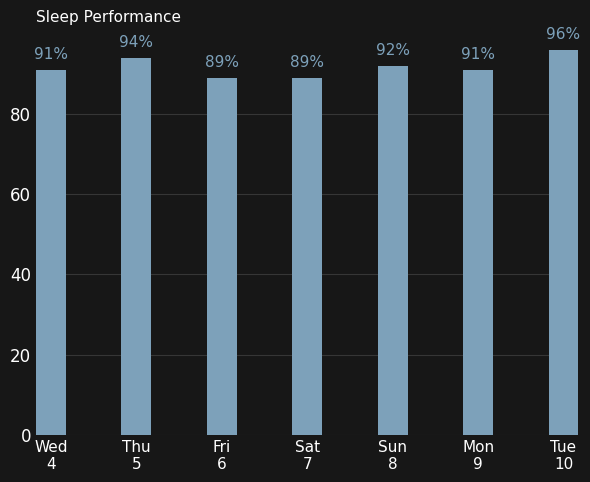

In [12]:
#@title 7.2 Sleep performance percentage weekly view
with plt.style.context('dark_background'):
    sleep_performance = extracted_df['sleep_performance_percentage'].iloc[start_idx-PLOT_LENGTH:start_idx]
    day = pd.to_datetime(extracted_df['start']).dt.strftime('%Y-%m-%d').iloc[start_idx-PLOT_LENGTH:start_idx]

    background_color = '#171717'

    plt.figure(figsize=(7,5), facecolor=background_color)
    # set background color *inside the figure*
    plt.gca().set_facecolor(color=background_color)

    # add horizontal grid
    plt.gca().grid(False)
    plt.gca().grid(axis='y', color='gray', alpha=0.3, zorder=0)
    plt.gca().set_axisbelow(True)
    # get rid of the axis lines
    for d in ["left", "top", "bottom", "right"]:
        plt.gca().spines[d].set_visible(False)

    day = day[::-1]
    sleep_performance = sleep_performance[::-1]
    bars = plt.bar(day, sleep_performance, width=0.35, color='#7da1ba', zorder=1)

    plt.xticks(ticks=np.arange(PLOT_LENGTH),
               labels=[day_label_to_fig_label(d) for d in day],
               fontsize=11)
    plt.tick_params(axis='x', which='both', bottom=False)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 2, str(round(yval, 2)) + '%', ha='center', va='bottom', color='#7da1ba', fontsize=11)
    plt.title('Sleep Performance', fontsize=11, loc='left', color='white', pad=20)

    plt.show()

# 8. Outlier Detection and Data Cleaning

Let us now catch some anomalies in our data.

Since our synthetic data has no obvious measurement-related anomalies, we manually inject one and verify that our method catches that anomaly but not any others. Let us go back to section 6.1, where we plotted the average heart rate over physiological cycles.

To identify outliers in our data, we'll use z-scores, which measure how far a data point deviates from the mean in terms of standard deviations, and is given by this formula:

$$
Z = \frac{\text{data point} - \text{mean of data set}}{\text{standard deviation}}
$$

This helps us gauge the likelihood of a data point being real. By setting a `threshold` value, we can define what constitutes an outlier. For instance, if a data point's z-score exceeds this threshold, it's likely an outlier.

**Step 1**: we calculate the z-scores for each data point in the average heart rate column. We then define a threshold value to determine outliers based on the absolute z-scores. Any data point with an absolute z-score greater than the threshold is considered an outlier.

In [13]:
filtered_df = cycles_df.copy()
filtered_df['start'] = pd.to_datetime(filtered_df['start'])
filtered_df = filtered_df[(filtered_df['start'] >= start_date) & (filtered_df['start'] <= end_date)]
dates = filtered_df['start'].dt.date
dates = dates[::-1]

cycle_scores = filtered_df['score']
res_column = cycle_scores.apply(lambda x: x['average_heart_rate'])
res_column[15] = 95
res_column[16] = 92

mean_res = np.mean(res_column)
std_res = np.std(res_column)
z_scores = (res_column - mean_res) / std_res

threshold = 3 #@param{type: "integer"}

outliers = np.abs(z_scores) > threshold


**Step 2**: we visualize the dataset using a scatter plot. Outliers are highlighted in blue, while non-outlier data points are shown in red. Additionally, the median, maximum, and minimum values of the dataset ignoring the outliers are annotated on the plot for reference.

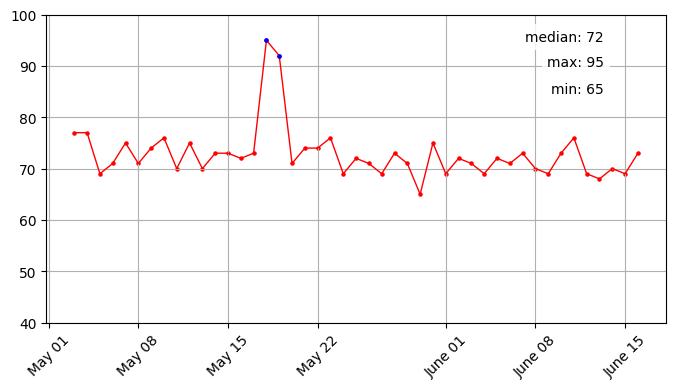

In [14]:
plt.figure(figsize=(8, 4))
plt.style.use('default')
max_1 = np.max(res_column)
min_1 = np.min(res_column)
med_1 = np.median(res_column)

plt.scatter(dates, res_column, s=5, c='r')
plt.plot(dates, res_column, c='r', linewidth=1)
plt.scatter(np.array(dates)[outliers], np.array(res_column)[outliers], color='b', s=5, zorder=3)
plt.ylim(bottom=40, top=100)
xticks = plt.xticks(rotation=45)
date_strings = [t.get_text() for t in plt.xticks()[1]]
formatted_dates = [pd.to_datetime(date_str).strftime("%B %d") for date_str in date_strings]
xticks = plt.xticks(ticks=plt.xticks()[0], labels=formatted_dates)
plt.grid(True)
plt.text(0.9, 0.95, f'median: {int(med_1)}', ha='right', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.text(0.9, 0.87, f'max: {int(max_1)}', ha='right', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.text(0.9, 0.78, f'min: {int(min_1)}', ha='right', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
plt.show()

To remove the outliers, we simply look into the data, see which datapoints have values that exceed the threshold, and remove the data.

In [15]:
def clean_data(data, z_threshold):
    mean_data = np.mean(data)
    std_data = np.std(data)
    z_scores = (data - mean_data) / std_data

    outliers = np.abs(z_scores) > z_threshold
    cleaned_data = data[~outliers]

    return cleaned_data

cleaned_avg_hr = clean_data(res_column, threshold)

Sometimes these anomalies arise from inaccuracies in measurement or external interferences. But it could also be a physiologial event. Gaining insight into their origins can guide how we address them during data analysis and may lead to improved data collection or processing methodologies.

# 9. Statistical Data Analysis

Data isn't much without some analysis, so we're going to do some in this section. Let's investigate the relationship between some of the data that we have collected.

The analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

## 9.1 Sleep performance v.s. total time in sleep

**Mini Research Question**: Is the sleep performance is correlated with the total time in sleep?

**Significance**: Understanding the relationship between sleep performance and total time spent in sleep is crucial for assessing the importance of sleep duration in overall sleep quality.

#### Step 1: Data Loading and Preparation

To see if this hypothesis is true, we would first pick out the sleep performance and total time in sleep data. We would have to process and clean the data as we did in the previous section. But since we are using synthetic data, we have not included this step here.

In [16]:
import seaborn as sns

sleep_performances = []
total_times = []

for index, row in sleeps_df.iterrows():
    sleep_performance = row['score']['sleep_performance_percentage']
    total_time = row['score'].get('stage_summary', {})['total_in_bed_time_milli']
    sleep_performances.append(sleep_performance)
    total_times.append(total_time)

data = {'sleep_performance_percentage': sleep_performances, 'total_in_bed_time_milli': total_times}
df = pd.DataFrame(data)
df['total_in_bed_time_hours'] = df['total_in_bed_time_milli'] / 3600000

#### Step 2: Plot sleep performance against total time in sleep
Next, we will use [seaborn](https://seaborn.pydata.org/generated/seaborn.jointplot.html) to plot the graph of sleep performance versus sleep time. The jointplot we have used lets us visualize the relationship between the two variables, and also shows us the distribution of the data on both axes.

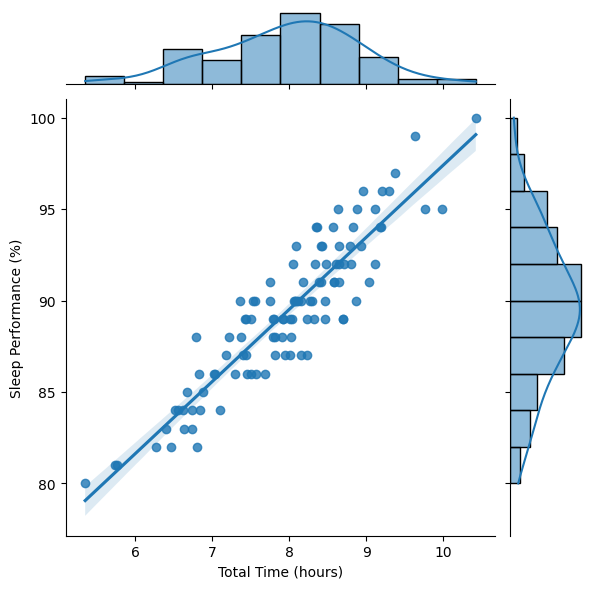

In [17]:
p = sns.jointplot(x='total_in_bed_time_hours', y='sleep_performance_percentage', data=df, kind='reg')
plt.xlabel('Total Time (hours)')
plt.ylabel('Sleep Performance (%)')
plt.ylim(top=101)
plt.show()

As we can see from the scatterplot above, it looks like there might be a correlation there. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination.

#### Step 3: Analyze the correlation
We will use `scipy` here to help us find out the values which will be important for us to study whether there is a correlation between the two variables.

In [18]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['total_in_bed_time_hours'], df['sleep_performance_percentage'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 3.94
Coefficient of determination: 0.834
p-value: 2.05e-42


The calculated slope suggests that for every additional hour of total time spent in bed, there is an average increase of about 3.94% in sleep performance percentage. This positive slope indicates a positive association between the length of sleep periods and sleep performance.

The coefficient of determination, also known as $R^2$, is approximately 0.834. This value indicates that approximately 83.4% of the variability in sleep performance percentage can be explained by the variability in the total time spent in bed. In other words, the linear regression model based on these variables captures a substantial portion of the variability in sleep performance.

The p-value associated with the slope, calculated to be $2.05 \times 10^{-42}$, is highly significant (less than 0.05). This suggests that there is a significant linear relationship between these variables.

## 9.2 Strain v.s. average heart rate

**Mini Research Question**: Is there a relationship between strain and average heart rate?

**Significance**: Understanding the relationship between strain and average heart rate can provide insights into how physical exertion affects cardiovascular activity.

#### Step 1: Data Loading and Preparation

Let us fetch the cycles dataframe and extract the strain and average heart rate information from it.

In [19]:
cycles_df = device.get_data("cycles", params=params)
strains = []
hr = []
for row in cycles_df['score']:
    strains.append(row['strain'])
    hr.append(row['average_heart_rate'])

data = {'strain': strains, 'average_heart_rate': hr}
df = pd.DataFrame(data)


#### Step 2: Plot strain against average heart rate
Just like the previous section, we will use [seaborn](https://seaborn.pydata.org/generated/seaborn.jointplot.html) to plot the graph.

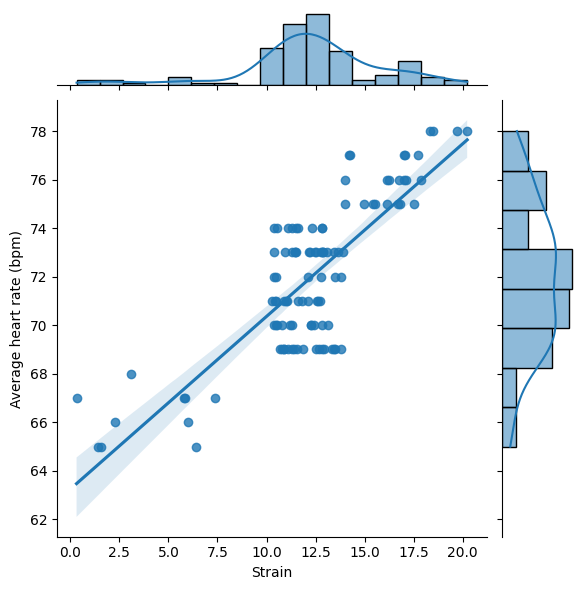

In [20]:
p = sns.jointplot(x='strain', y='average_heart_rate', data=df, kind='reg')
plt.xlabel('Strain')
plt.ylabel('Average heart rate (bpm)')

plt.show()

#### Step 3: Analyze the correlation

Finally, we look into the correlation quantifiers returned from `linregress` and study if there is indeed a correlation between the two variables we studied.

In [21]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['strain'], df['average_heart_rate'])

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 0.712
Coefficient of determination: 0.652
p-value: 8.52e-26


Looks significant (<0.05)!